In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skmultiflow.data.file_stream import FileStream
from skmultiflow.anomaly_detection import HalfSpaceTrees
from source.iforestasd_scikitmultiflow import IsolationForestStream
from skmultiflow.evaluation.evaluate_prequential import EvaluatePrequential
import glob
from collections import deque
import dask.dataframe as da
import itertools
import datetime
import time
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score, classification_report
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("datasets/revised_sub20_data_2ndV.csv")

## Exploratory Data Analysis 

In [3]:
data.iloc[:,4:].head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,type,row_num,outlier
0,1.172703,-1.217849,0.633634,0.318633,0.938358,-0.134000,-1.221689,0.095745,0.650700,0.597170,0.081509,-0.071948,dws,0,0
1,1.230989,-1.218272,0.702610,0.325523,0.938504,-0.115079,-0.724416,-0.825562,0.181063,0.140922,2.183841,-0.698596,dws,1,0
2,1.220374,-1.217347,0.695971,0.325099,0.938184,-0.118826,0.424864,0.286293,0.057343,0.091450,-0.118314,0.177435,dws,2,0
3,1.196626,-1.215197,0.674119,0.324063,0.937438,-0.127249,0.289479,-0.389842,-0.170267,-0.001020,0.076020,0.182624,dws,3,0
4,1.183103,-1.220570,0.669148,0.317645,0.939295,-0.129714,-0.193776,-0.518626,-0.312347,0.015118,-0.019785,0.194854,dws,4,0


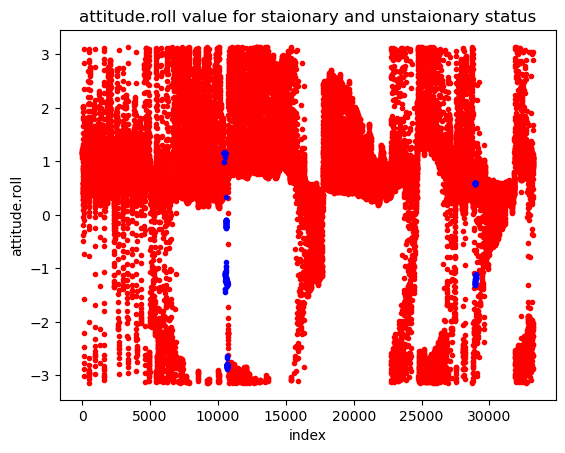

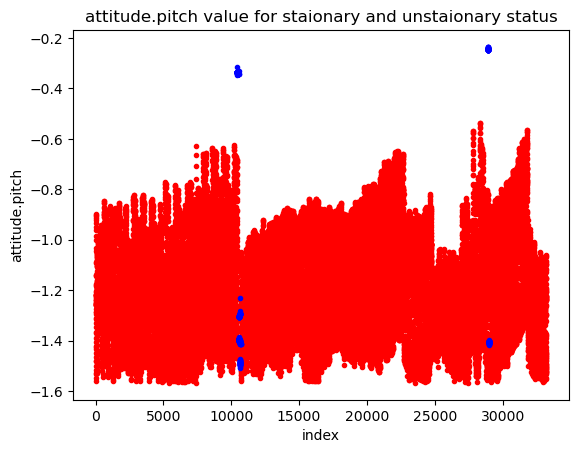

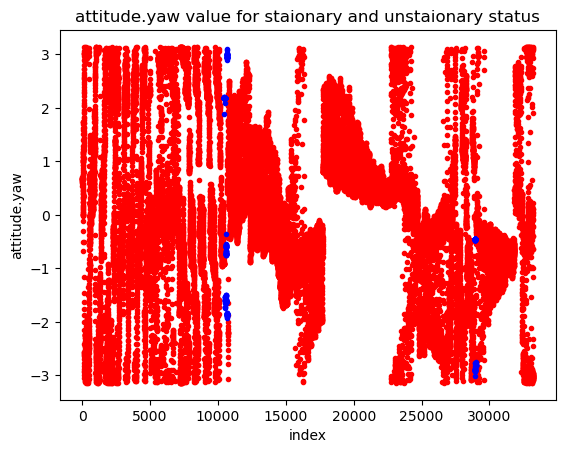

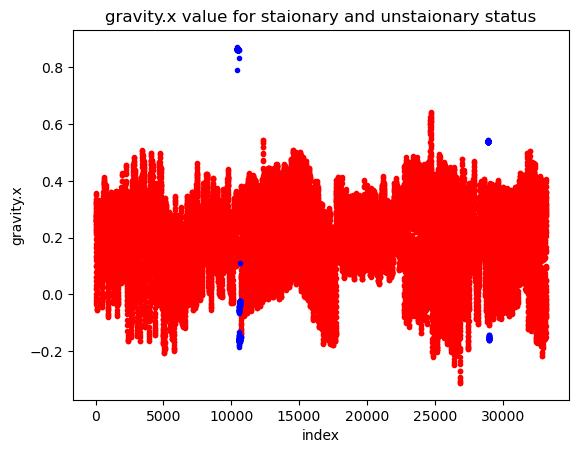

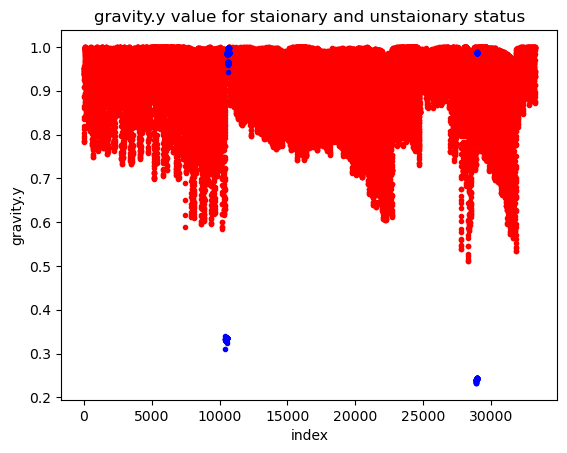

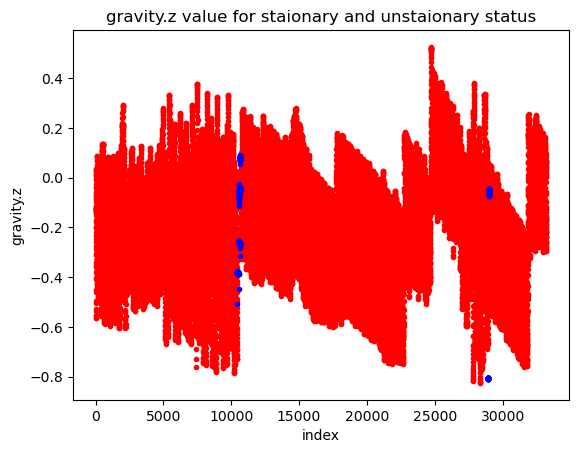

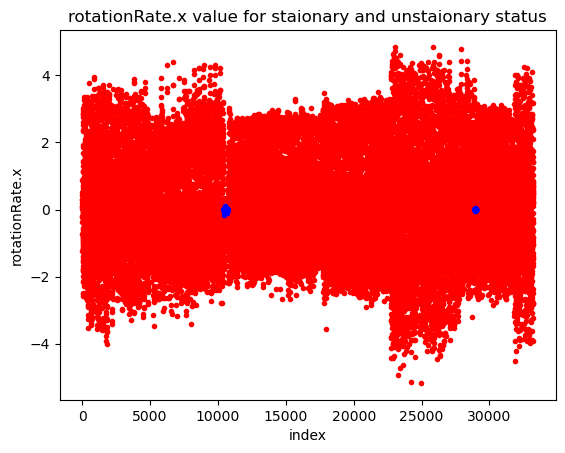

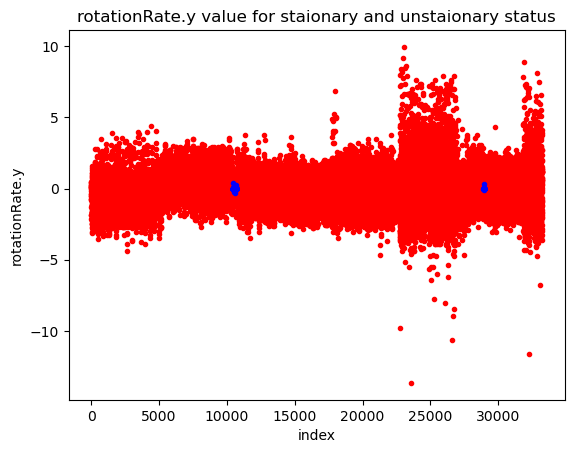

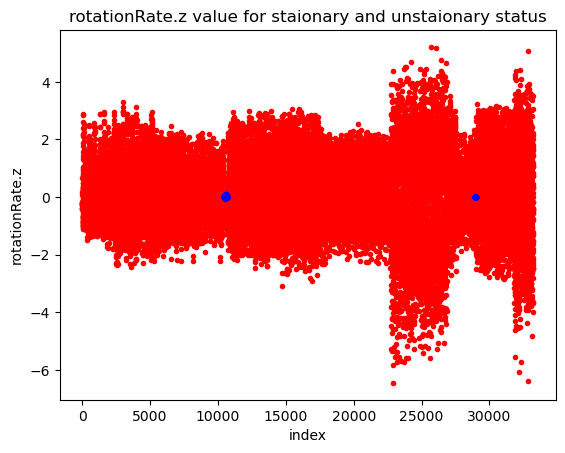

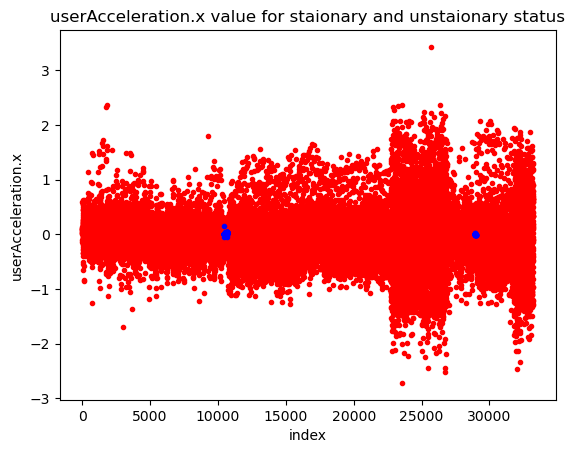

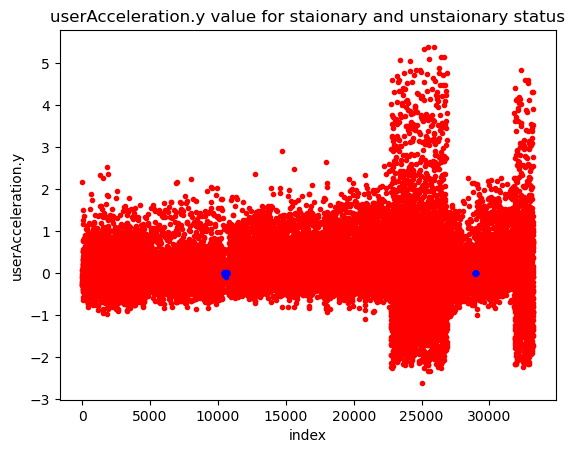

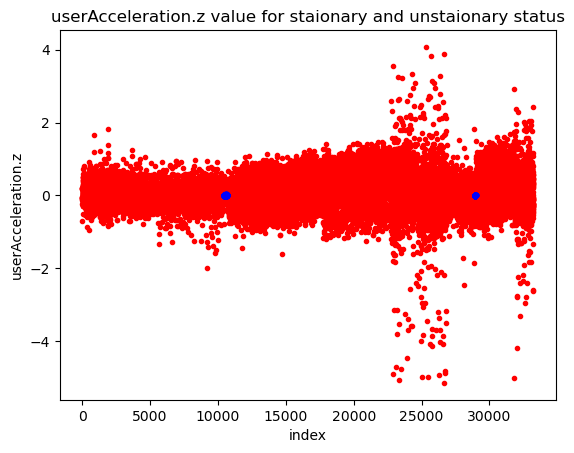

In [4]:
features = ['attitude.roll', 'attitude.pitch', 'attitude.yaw', 'gravity.x', 'gravity.y', 'gravity.z', 'rotationRate.x', 'rotationRate.y', 'rotationRate.z', 'userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']
for i in range(len(features)):
    plt.scatter(data[data['outlier']==0].index, data[data['outlier']==0][[features[i]]], c='r', marker='.')
    plt.scatter(data[data['outlier']==1].index, data[data['outlier']==1][[features[i]]], c='b', marker='.')
    plt.xlabel('index')
    plt.ylabel(features[i])
    plt.title(features[i] + ' value for staionary and unstaionary status')
    plt.show()

The MotionSense dataset contains data that records people's movements. There are 6 types of movement status, walking, going upstairs, going downstaris, jogging, standing, and sitting. Standing and sitting are stationary status and are treated as outliers because some of their attributes are very different from other status.

In [5]:
# Number of instances of different status
data[['type']].value_counts()

type
wlk     14901
ups      6719
dws      5752
jog      5528
std       175
sit       157
dtype: int64

There are 33232 instances in total, 332 of which are stationary status. Stationary status instances are around 1% of the total instances.

## Outlier Detection Using Half Space Tree Method

#### Implementing Half Space Tree using skmultiflow library

In [3]:
# Read data chunk by chunk. Each chunk has 1000 rows
numbers = re.compile(r'(\d+)')

def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

all_files = sorted(glob.glob(r"datasets/revised_sub20_data_2ndV.csv"), key=numericalSort)
li = []

window_len = 1000
buffer = deque()
for file in all_files:
    window_start = 0
    dfs = pd.read_csv(all_files[0], iterator = True, chunksize = window_len)
    for idx, df in enumerate(dfs):
        buffer.append(df)

In [4]:
# The first three chunks of data is used as reference and they are treated as normal data.
outlier_buffer = deque()
reference = pd.DataFrame()
reference_start = 3
reference = pd.concat(list(itertools.islice(buffer, 0, reference_start)))

In [5]:
# Initialize a Half Space Tree model and specify hyperparameter values
HST_model = HalfSpaceTrees(random_state = 1, anomaly_threshold= 0.8)
# Fit the Half Space Tree model with the reference data
HST_model.fit(reference.iloc[:, 4:16].values, np.array(reference.outlier))

HalfSpaceTrees(anomaly_threshold=0.8, depth=15, n_estimators=25, random_state=1,
               size_limit=50, window_size=250)

In [6]:
# Simulate data as streaming data and make predictions using the Half Space Tree model.
# Record the average prediction accuracy for each chunk of data
accuracy = []
# Record the average time used for making prediction for each row and partially fit the model.
times = []
for i in range(len(buffer)):
    if i < reference_start:
        continue
    # Initialize a Half Space Tree model and specify hyperparameter values
    HST_model = HalfSpaceTrees(random_state = 1, anomaly_threshold= 0.8)
    # Fit the Half Space Tree model with the reference data
    HST_model.fit(reference.iloc[:, 4:16].values, np.array(reference.outlier))

    predict = []
    for j in range(len(buffer[i])):
            start = time.time()
            # Make prediction
            pred = HST_model.predict([list(buffer[i].iloc[j,4:16].values)])
            if (pred[0] == 0):
                # Partically fit the Half Space with the new incoming data
                HST_model.partial_fit(np.array([buffer[i].iloc[j,4:16].values]), [pred[0]])
            times.append(time.time() - start)
            predict.append(pred[0])
            
    buffer[i]['pred'] = predict
    buffer[i]['matched'] = np.where(buffer[i]['outlier'] == buffer[i]['pred'], 1, 0)

    print(f"Results for idx = {i} and rows from {buffer[i].index.min()} to {buffer[i].index.max()} is")
    acc = sum(buffer[i]['matched'])/len(buffer[i]['matched'])
    print('Accuracy is ' + str(acc))
    accuracy.append(acc)

Results for idx = 3 and rows from 3000 to 3999 is
Accuracy is 0.659
Results for idx = 4 and rows from 4000 to 4999 is
Accuracy is 0.751
Results for idx = 5 and rows from 5000 to 5999 is
Accuracy is 0.715
Results for idx = 6 and rows from 6000 to 6999 is
Accuracy is 0.579
Results for idx = 7 and rows from 7000 to 7999 is
Accuracy is 0.473
Results for idx = 8 and rows from 8000 to 8999 is
Accuracy is 0.611
Results for idx = 9 and rows from 9000 to 9999 is
Accuracy is 0.502
Results for idx = 10 and rows from 10000 to 10999 is
Accuracy is 0.641
Results for idx = 11 and rows from 11000 to 11999 is
Accuracy is 0.649
Results for idx = 12 and rows from 12000 to 12999 is
Accuracy is 0.714
Results for idx = 13 and rows from 13000 to 13999 is
Accuracy is 0.735
Results for idx = 14 and rows from 14000 to 14999 is
Accuracy is 0.761
Results for idx = 15 and rows from 15000 to 15999 is
Accuracy is 0.782
Results for idx = 16 and rows from 16000 to 16999 is
Accuracy is 0.873
Results for idx = 17 and ro

In [7]:
# Combine all chunks of data
combined_dat = buffer[3]
for i in range(4,len(buffer)):
    combined_dat = pd.concat([combined_dat, buffer[i]])

In [9]:
# Prediction Evaluation
# Confusion Matrix
print("*****confusion matrix*****")
print(pd.DataFrame(confusion_matrix(list(combined_dat['outlier']),list(combined_dat['pred']))))

true_labels = list(combined_dat['outlier']) 
predicted_labels = list(combined_dat['pred'])

# Calculate precision, recall, and F1 score
print("******classification report*******")
report = classification_report(true_labels, predicted_labels, digits=4)
print(report)

print("******averge time used to predict and partially fit the model for each chunk******")
print(str(np.mean(np.array(times))) + " seconds running in MSiA Jupyter Hub")

# There are 1000 rows in each chunk
print("******averge time used to predict and partially fit the model for each row******")
print(str(np.mean(np.array(times))/1000) + " seconds running in MSiA Jupyter Hub")

*****confusion matrix*****
       0     1
0  20337  9563
1    189   143
******classification report*******
              precision    recall  f1-score   support

           0     0.9908    0.6802    0.8066     29900
           1     0.0147    0.4307    0.0285       332

    accuracy                         0.6774     30232
   macro avg     0.5028    0.5554    0.4175     30232
weighted avg     0.9801    0.6774    0.7981     30232

******averge time used to predict and partially fit the model for each chunk******
0.0016264016033953918 seconds running in MSiA Jupyter Hub
******averge time used to predict and partially fit the model for each row******
1.6264016033953918e-06 seconds running in MSiA Jupyter Hub


Comments: \
Half Space Tree model performs okay on detecting outliers. \
Accuracy: 0.6774 \
Macro averaged precision: 0.5028 \
Macro averaged recall: 0.5554 \
Macro averaged f1-score: 0.4175 

#### Implementing Half Space Tree and iForestASD using functions in source code

In [10]:
from source import functions
func = functions.Comparison()

In [11]:
window_sizes = [50, 100]
n_estimators = [30, 50]
anomaly_threshold = 0.8
max_sample = data.shape[0]
n_wait = max_sample 
metrics=['accuracy', 'f1', 'precision', 'recall', 'true_vs_predicted', 'running_time', 'model_size'] 

In [ ]:
anomaly_threshold = 0.8
MotionSenseStream = FileStream('datasets/revised_sub20_cleandata_forStream.csv', n_targets=1, target_idx=-1)
test_name = 'Revised_MotionSense'+'_'+str(datetime.datetime.now())
for window in window_sizes:
    for n_estimator in n_estimators:
        print("")
        print("******************************** Window = "+str(window)+" and n_estimator = "+str(n_estimator)+" ********************************")
        func.run_comparison(stream=MotionSenseStream, window = window, 
                             estimators = n_estimator, anomaly = anomaly_threshold, 
                             result_folder=test_name, max_sample=max_sample, n_wait=n_wait, metrics=metrics)


******************************** Window = 50 and n_estimator = 30 ********************************
Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 1 sample(s).
Evaluating...
 #################### [100%] [5924.11s]
Processed samples: 33232
Mean performance:
HSTrees - Accuracy     : 0.0115
HSTrees - Precision: 0.0100
HSTrees - Recall: 1.0000
HSTrees - F1 score: 0.0198
HSTrees - Training time (s)  : 236.89
HSTrees - Testing time  (s)  : 14.78
HSTrees - Total time    (s)  : 251.68
HSTrees - Size (kB)          : 195843.4570
iForestASD - Accuracy     : 0.9885
iForestASD - Precision: 0.3300
iForestASD - Recall: 0.3328
iForestASD - F1 score: 0.4419
iForestASD - Training time (s)  : 75.20
iForestASD - Testing time  (s)  : 5595.90
iForestASD - Total time    (s)  : 5671.10
iForestASD - Size (kB)          : 8005.5205

Please find evaluation results here results/Revised_MotionSense_2023-06-02 16:34:10.650431/result_for_WS50_NE30.csv

******************************** Window = 50 and 

Comments: \
It takes a long time to run the iForestASD algorithm even in MSiA Jupyter Hub. Based on the observation, when window size = 50 and n_estimator = 30, iForestASD performs better than Half Space Tree measured by accuracy, precision, recall, and f1 score. 